# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [5]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [9]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [10]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [13]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [14]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [16]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [18]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302109, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301968, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301922, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301719, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302023, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302507, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302557, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302218, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302172, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300735, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302746, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301928, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302068, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301485, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302554, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302095, Train acc

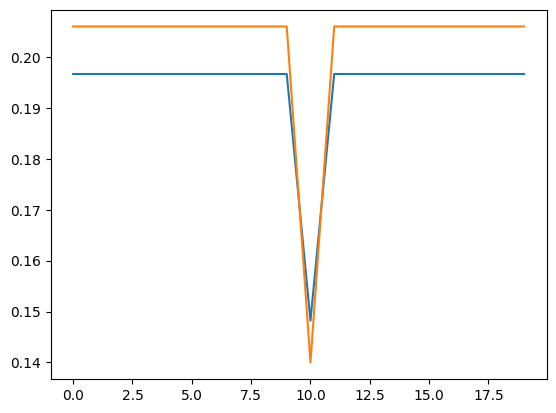

In [19]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [20]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.264089, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.197698, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262334, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.268750, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315680, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.198290, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264118, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.239789, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.238604, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248965, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.220957, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266441, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.247251, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278941, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299855, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.208232, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [21]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.322913, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307057, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308139, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303941, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273144, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299483, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293231, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.268944, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305786, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265465, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280080, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.269183, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300779, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.246529, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314200, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277472, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [44]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.342957, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.311636, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.332834, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.316330, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.282238, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.233325, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.230714, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.202673, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.335559, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.332069, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.722193, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.078666, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.076003, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.740053, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.019229, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.947468, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [46]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-4)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=2)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.373770, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300900, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.143942, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 2.096853, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 3.318442, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.945372, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.456275, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.848604, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.745256, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.463539, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.021869, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.380531, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 0.711171, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 2.310054, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 0.006860, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 0.007008, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [48]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1, 1e-2]
reg_strength = [1e-3, 1e-5]
hidden_layer_sizes = [64, 128, 256]
batch_size = [64, 128]
num_epochs = 16

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

dataset = Dataset(train_X, train_y, val_X, val_y)

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
for lr in learning_rates:
    for rs in reg_strength:
        for ls in hidden_layer_sizes:
            for bs in batch_size:
                model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=ls, reg=rs)
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=bs)
                temp_loss_history, temp_train_history, temp_val_history = trainer.fit()
                
                if temp_val_history[-1] > best_val_accuracy:
                    best_classifier = model
                    best_val_accuracy = temp_val_history[-1]
                    loss_history = temp_loss_history.copy()
                    train_history = temp_train_history.copy()
                    val_history = temp_val_history.copy()

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 1.908314, Train accuracy: 0.303333, val accuracy: 0.308000
Loss: 1.587410, Train accuracy: 0.543333, val accuracy: 0.569000
Loss: 1.470515, Train accuracy: 0.594667, val accuracy: 0.560000
Loss: 1.835399, Train accuracy: 0.573222, val accuracy: 0.548000
Loss: 1.510640, Train accuracy: 0.578556, val accuracy: 0.581000
Loss: 1.616622, Train accuracy: 0.613556, val accuracy: 0.589000
Loss: 1.212909, Train accuracy: 0.590444, val accuracy: 0.576000
Loss: 1.264907, Train accuracy: 0.622222, val accuracy: 0.596000
Loss: 1.477225, Train accuracy: 0.624889, val accuracy: 0.585000
Loss: 1.525557, Train accuracy: 0.616444, val accuracy: 0.598000
Loss: 1.691976, Train accuracy: 0.632889, val accuracy: 0.593000
Loss: 1.570408, Train accuracy: 0.651222, val accuracy: 0.620000
Loss: 1.600679, Train accuracy: 0.648111, val accuracy: 0.600000
Loss: 1.346096, Train accuracy: 0.675333, val accuracy: 0.647000
Loss: 2.285592, Train accuracy: 0.605222, val accuracy: 0.564000
Loss: 1.607015, Train acc

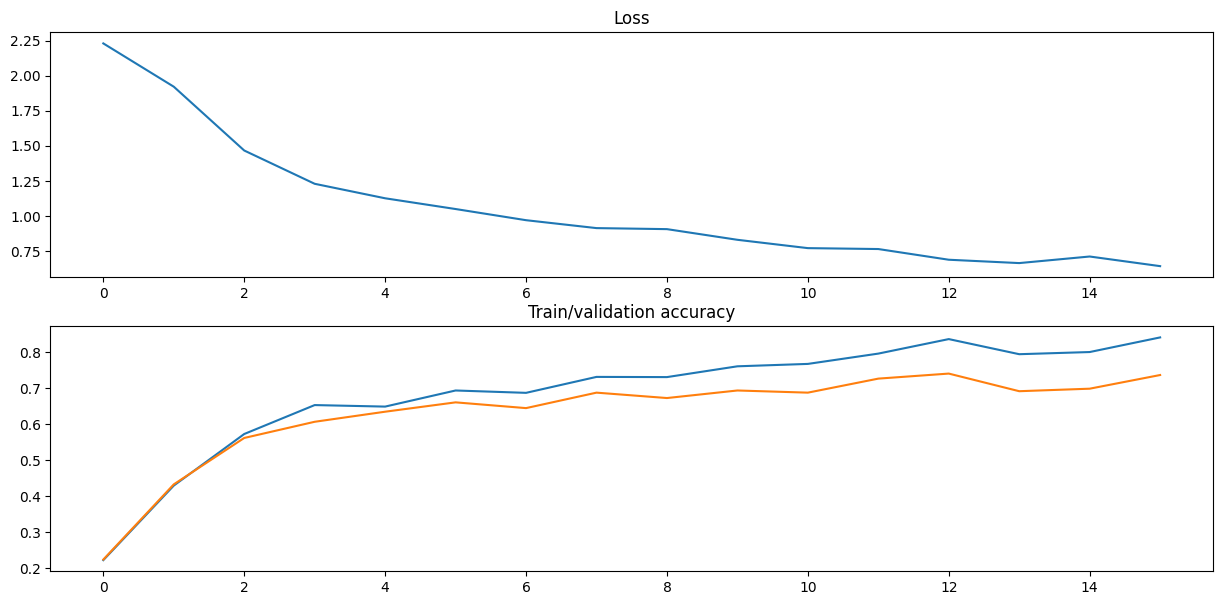

In [49]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [50]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.702000
